In [14]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim



# Getting the data
We start by generating a simple data, taken from a Gaussian and we label it such that simple linear regression fails

In [15]:
def getData(n):
    
    X = torch.randn(n,2)
    return X

def getLabel(X):
    
    Y      = torch.zeros(X.shape[0])
    ind    = X[:,0]**2 + X[:,1]**2 > 1
    Y[ind] = 1.0
    return Y, ind


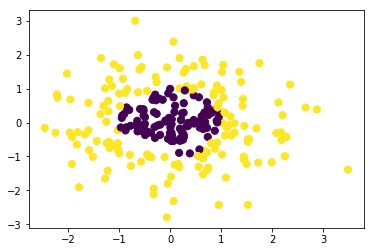

In [16]:
X      = getData(250)
Y, ind = getLabel(X)

plt.figure(1)
plt.scatter(X[:,0],X[:,1],c=Y.numpy(),s=np.ones(Y.shape)+50,cmap='viridis')
plt.show()


Now, design a Hamiltonan network
$$ \dot{Z} = \sigma(K(t)X + B(t)) \quad \dot{X} = -\sigma(K(t)^TZ + B(t)) $$

Note, the dimensions of $X$ is always 2 but the dimensions of $Z$ is arbitrary, allows us to be more expressive 

In [17]:
def hamiltonianNet(Kopen,K,B,X,h):
    
    nt = len(K)
    Z  = torch.tanh(X@Kopen)
    for i in range(nt):
        Ki = K[i]
        Bi = B[i]
        
        Z    = Z + h*torch.relu(X@Ki + Bi)
        X    = X - h*torch.relu(Z@(Ki.t()) + Bi)    
        
    return X


In [25]:
nwide = 20
nlayers = 100
Kopen = torch.randn(2,nwide)
K = []
B = []
for i in range(nlayers):
    Ki = torch.randn(2,nwide)*1e-2
    Bi = torch.randn(1)*1e-4
    K.append(Ki)
    B.append(Bi)

B.append(torch.randn(1)*1e-4)    

W = torch.randn(2)
W = W - W.mean()

h = 1/nlayers

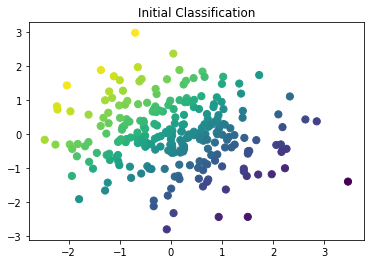

In [26]:
# Run the network and plot results
Xpred = hamiltonianNet(Kopen,K,B,X,h)
Ypred = Xpred@W + B[-1] 
p  = 1/(1 + torch.exp(-Ypred))
plt.figure(2)
plt.scatter(Xpred[:,0],Xpred[:,1],c=p.numpy(),s=np.ones(p.shape)+50,cmap='viridis')
plt.title('Initial Classification')
plt.show()


# Define  a function for regularization
$$ TV(K) = \int_0^1 |\dot K(t)|\ dt $$

# Define the logistic regression for loss 
$$ p = (1 + \exp(-Y))^{-1}. $$ 

In [27]:
def TVK(K):
    nt = len(K)
    nrmk = 0.0
    for i in range(nt-1):
        dK = K[i+1]-K[i]
        nrmk = nrmk + torch.norm(dK)
        
    return nrmk    

def lossCE(Y,Yobs):
    p    = 1/(1 + torch.exp(-Y))
    loss = torch.dot(Yobs,torch.log(p+1e-16)) + torch.dot(1-Yobs,torch.log(1-p+1e-16))
    n    = Y.shape[0]
    return -loss/n


In [28]:
# now train the system
W      = nn.Parameter(W)
Kopen  = nn.Parameter(Kopen)

K = [nn.Parameter(Ki) for Ki in K]
B = [nn.Parameter(Bi) for Bi in B]


In [29]:
# Define optimization parameters
lr        = 1e-1
batchSize = 64
niter     = 1000
alpha     = 1e-2
optimizer = optim.Adam([{'params':Kopen},{'params':K},{'params':B},{'params': W}], lr=lr)

runningLoss = 0
for ii in range(niter):
  ind = torch.randint(0,X.shape[0],[batchSize])
  Xi  = X[ind,:]
  Yi  = Y[ind]
        
  # Forward Pass
  optimizer.zero_grad()
  Z = hamiltonianNet(Kopen,K,B,Xi,h)

  # Apply classifier
  YiPred = Z@W + B[-1]
  misfit = lossCE(YiPred,Yi)
            
  # Calc loss and backprop
  TV = TVK(K)
  loss = misfit + alpha*TV
  loss.backward()
  optimizer.step()

  runningLoss += loss.item()

  if ii%100 == 0:
      print(ii, runningLoss/(ii+1),TV.item())
  if runningLoss/(ii+1)<5e-2:
      break
 

0 0.849915623664856 8.951774597167969
100 0.690713377872316 4.886038303375244
200 0.5750384774077592 4.424568176269531
300 0.4952344228064895 4.894155979156494
400 0.4241469121559005 5.044200897216797
500 0.3735174255486496 4.7080888748168945
600 0.34167042058488095 4.987514972686768
700 0.31435997152804646 4.77289342880249
800 0.2935998538571797 4.607687473297119
900 0.27408312508354704 4.724851131439209


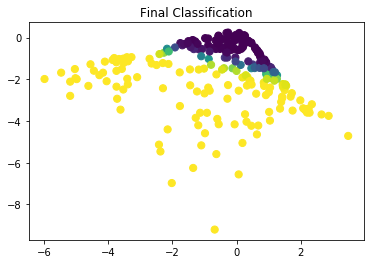

In [30]:
# Run the network and plot results
Xpred = hamiltonianNet(Kopen,K,B,X,h)
Ypred = Xpred@W + B[-1] 
p  = 1/(1 + torch.exp(-Ypred))
plt.figure(2)
plt.scatter(Xpred[:,0].detach().numpy(),Xpred[:,1].detach().numpy(),c=p.detach().numpy(),s=np.ones(p.shape)+50,cmap='viridis')
plt.title('Final Classification')
plt.show()
